<h1><center>Machine Learning Assignment - Video Memorability Prediction</center></h1>

<h1><center>
CA684 Machine Learning<br>
Masters in Computing (Data Analytics)<br>
19211191 <br>
Sachin Mahesh
</center></h1>

## Google Colab Setup

In [0]:
from google.colab import drive
import os
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/CA684_Assignment/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


## Import and Installing packages

Few main pakages used in this project are as follows:

> * **pyprind:** The PyPrind (Python Progress Indicator) module provides a progress bar and a percentage indicator object that let you track the progress of a loop structure or other iterative computation.
> * **Keras:** is an open-source neural-network library written in Python. It is capable of running on top of TensorFlow. Designed to enable fast experimentation with deep neural networks.
> * **TensorFlow:** is a free and open-source software library for dataflow and differentiable programming across a range of tasks. It is a symbolic math library, and is also used for machine learning applications such as neural networks.
> * **Scikit-learn:** is a machine learning library for the Python. It features various classification, regression and clustering algorithms including support vector machines, random forests.



In [0]:
!pip install pyprind
!pip install -U keras
!pip install keras
!pip install tensorflow

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)


In [0]:
import pandas as pd
import keras
from keras import Sequential, layers, regularizers, optimizers
import numpy as np
from string import punctuation
import pyprind
from collections import Counter
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy import stats
from natsort import natsorted,ns

## Setting seed for reproducibility

By doing so our program generates the same set of random inputs to help us reproduce the results later

In [0]:
import tensorflow as tf
tf.random.set_seed(1234)

## Spearman's Correlation Function To Calculate Memorability Score

>  **Spearman's rank correlation coefficient :** is a nonparametric measure of rank correlation (statistical dependence between the rankings of two variables). It assesses how well the relationship between two variables can be described using a linear function. 

In [0]:
def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])

## Features

---
We are going to load 3 features from the dataset.

*   Convolution 3D (C3D) -- Generic features generated for video analysis.
> C3D is obtained by training a deep 3D convolutional network on a large annotated video dataset. The dataset contains various concepts encompassing objects, actions, scenes and other frequently occurring categories in videos.

*   Histogram of Motion Patterens (HMP) -- Histogram of motion patterns generated for each video
> HMP is a static image template which helps in understanding the motion location and path as it progresses. The temporal motion information is collapsed into a single image template where intensity is a function of recency of motion, where brighter values correspond to a more recent motion.

*  Captions -- Textual features describing the videos.
> Captions provide a textual description of an video based on the objects and actions in it.





### Functions for Loading different Features

In [0]:
# captions
def read_caps(fname):
    """Load the captions into a dataframe"""
    vn = []
    cap = []
    df = pd.DataFrame();
    with open(fname) as f:
        for line in f:
            pairs = line.split()
            vn.append(pairs[0])
            cap.append(pairs[1])
        df['video']=vn
        df['caption']=cap
    return df
 
# loading C3D
def read_C3D(fname):
    with open(fname) as f:
        for line in f:
            C3D =[float(item) for item in line.split()] 
    return C3D
  
# loading HMP
def read_HMP(fname):
    """Scan HMP(Histogram of Motion Patterns) features from file"""
    with open(fname) as f:
        for line in f:
            pairs=line.split()
            HMP_temp = { int(p.split(':')[0]) : float(p.split(':')[1]) for p in pairs}
    # there are 6075 bins, fill zeros
    HMP = np.zeros(6075)
    for idx in HMP_temp.keys():
        HMP[idx-1] = HMP_temp[idx]            
    return HMP

## Declaring Source Paths And Variables
> Ground Truth values are loaded as labels and contains:
*   Video's name
*   Short-term memorability score.
*   Number of annotations which was used to calculate its short-term memorability score.
*   Long-term memorability score.
*   Number of annotations which was used to calculate its long-term memorability score.








In [0]:
# load the captions
cap_path = './Dev-set/Captions/dev-set_video-captions.txt'
df_cap=read_caps(cap_path)

# load the ground truth values
label_path = './Dev-set/Ground-truth/ground-truth.csv'
labels=pd.read_csv(label_path)

# Path for the features
Feat_path = '/content/drive/My Drive/CA684_Assignment/Dev-set/'

#getting video names using features' name
def getnames(featurename):
  vnames = os.listdir(Feat_path+featurename)
  return vnames

#get full path of the features using features' name 
def getpaths(featurename):
  fpath = [Feat_path+featurename+'/' + x for x in  getnames(featurename)]
  sorted = natsorted(fpath,alg=ns.IGNORECASE)
  print('Feature Path:')
  print(sorted[:5])
  return sorted


### Functions Definitions
> For reading HMP and C3D text files into an numpy array



In [0]:
#load C3D and return as an array of list
def df_C3D():
  path = getpaths('C3D')
  c3d = []
  print('Loading C3D')
  for item in path:
    c3d.append(read_C3D(item))
  print('done')
  return np.asarray(c3d)

#load HMP and return as an array of list
def df_HMP():
  path = getpaths('HMP')
  hmp = []
  print('Loading HMP')
  for item in path:
    hmp.append(read_HMP(item))
  print('done')
  return np.asarray(hmp)

### Loading C3D and HMP features.

In [0]:
#loading C3D
feature1 = df_C3D()

Feature Path:
['/content/drive/My Drive/CA684_Assignment/Dev-set/C3D/video3.txt', '/content/drive/My Drive/CA684_Assignment/Dev-set/C3D/video4.txt', '/content/drive/My Drive/CA684_Assignment/Dev-set/C3D/video6.txt', '/content/drive/My Drive/CA684_Assignment/Dev-set/C3D/video8.txt', '/content/drive/My Drive/CA684_Assignment/Dev-set/C3D/video10.txt']
Loading C3D
done


In [0]:
feature2 = df_HMP()

Feature Path:
['/content/drive/My Drive/CA684_Assignment/Dev-set/HMP/video3.txt', '/content/drive/My Drive/CA684_Assignment/Dev-set/HMP/video4.txt', '/content/drive/My Drive/CA684_Assignment/Dev-set/HMP/video6.txt', '/content/drive/My Drive/CA684_Assignment/Dev-set/HMP/video8.txt', '/content/drive/My Drive/CA684_Assignment/Dev-set/HMP/video10.txt']
Loading HMP
done


## Cleaning / Preprocessing of features

### Optimizing captions

Natural language toolkit library has be used to optimize the captions.

In [0]:
from nltk.stem import WordNetLemmatizer
from nltk import tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import re

> Stripping Special Characters

In [0]:
df = df_cap.copy()
import re
def strip_character(dataCol):
    r = re.compile(r'[^a-zA-Z]')
    return r.sub(' ', str(dataCol))

df['caption'] = df['caption'].apply(strip_character)

In [0]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True



> Removing Stopwords



In [0]:
stop = stopwords.words('english') 

In [0]:
df['caption'] = df['caption'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))
df['caption'].head()

0                   blonde woman massaged tilt
1    roulette table spinning ball closeup shot
2                                khr gangsters
3            medical helicopter hovers airport
4            couple relaxing picnic crane shot
Name: caption, dtype: object



> Lemmatization
*   Lemmatisation is a process of grouping words together which inflict same forms of a word so they can be analysed as a single item.

In [0]:
df['caption'] = [''.join([WordNetLemmatizer().lemmatize(re.sub('[^A-Za-z]',' ',text)) for text in lis]) for lis in df['caption']]
df['caption'].head()

0                   blonde woman massaged tilt
1    roulette table spinning ball closeup shot
2                                khr gangsters
3            medical helicopter hovers airport
4            couple relaxing picnic crane shot
Name: caption, dtype: object



> Extracting Unique Word Count



In [0]:
counts = Counter()
# pbar = pyprind.ProgBar(len(df['caption']), title='Counting word occurrences')
for i, cap in enumerate(df['caption']):
    counts.update(cap.split())   

In [0]:
df.caption.values

array(['blonde woman massaged tilt',
       'roulette table spinning ball closeup shot', 'khr gangsters', ...,
       'students walking university mexico', 'beautiful black woman spa',
       'beautiful modern brunette woman using tablet computer luxury bed'],
      dtype=object)



> n-Gram approach using TF - IDF




In [0]:
vect = TfidfVectorizer(ngram_range = (1,4)).fit(df.caption)
vect_transformed_X_train = vect.transform(df.caption)
len_token = len(vect.get_feature_names())

In [0]:
len_token

59584



>  Maping each unique word in the vector to an integer (one-hot encoding)


*   Building word index by using tokenizer
*   Fitting a list of captions to the tokinizer
> tokenizer vectorizes a text corpus, by turning each text into a sequence of integers





In [0]:
len_token = len(counts)
tokenizer = Tokenizer(num_words=len_token)

In [0]:
tokenizer.fit_on_texts(list(vect.get_feature_names()))

In [0]:
captions = tokenizer.texts_to_matrix(list(df.caption.values),mode='binary')

In [0]:
len(captions)

6000

In [0]:
#Checking length. Output should be (6000,6000)
print(len(feature1),len(feature2))

6000 6000


## Model Implementations
>Models that I have chosen to process futher are:
*    Regions with CNN (Convolutional Neural Networks)
*    Linear Regression
*    Support Vector Regression (SVR)
*    Random Forest Regression
*    Rigid Regression
*    Ensemble approach using SVR, Decision Trees, Linear Regression as base estimators and Rigid Regression as final estimator



### R-CNN
> While loading X_NN variable we can either run individual features or choose to combine multiple features like 
*    Each feature seperatly (Captions, C3D, HMP) or
*    Combine 2 features together ( Captions + C3D, Captions + HMP, HMP + C3D) or
*    Combine all 3 features together (C3D + HMP + Captions)


```
C3D: feature1, HMP: feature2 ,Captions: captions
X_NN = np.concatenate((feature1, feature2, captions), axis=1)
```





<b>Construction</b>


A dense layer is just a regular layer of neurons in a NN. Each neuron recieves input from all the neurons in the previous layer, thus densely connected. 


![alt text](http://www.ece.utep.edu/research/webfuzzy/docs/kk-thesis/kk-thesis-html/img33.gif)


The layer has a weight matrix W, a bias vector b, and the activations of previous layer a. The following is the docstring of class Dense from the keras documentation:

*output = activation(dot(input, kernel) + bias)*

where activation is the element-wise activation function passed as the activation argument, kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer

#### Using Captions

In [0]:
#Short term and long term memorability score 
Y_NN = labels[['short-term_memorability','long-term_memorability']].values
X_NN = captions



>Splitting dataset into test and train set with 90 : 10 ratio



In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X_NN,Y_NN, test_size=0.10, random_state=42)

In [0]:
# adding dropout and regularizers
model = Sequential()
model.add(layers.Dense(30,activation='selu',kernel_regularizer=regularizers.l2(0.00001)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(25,activation='selu',kernel_regularizer=regularizers.l2(0.00001)))
model.add(layers.Dropout(0.7))
model.add(layers.Dense(2,activation='selu'))

# compiling the model 
opt = optimizers.RMSprop(lr=0.0009, rho=0.89, decay=0.0)
model.compile(optimizer=opt,loss='mse',metrics=['accuracy'])

history = model.fit(X_train,Y_train,epochs=22,validation_data=(X_test,Y_test))

Train on 5400 samples, validate on 600 samples
Epoch 1/22
5400/5400 [==============================] - 1s 201us/step - loss: 0.1976 - accuracy: 0.5080 - val_loss: 0.0300 - val_accuracy: 0.6767
Epoch 2/22
5400/5400 [==============================] - 1s 169us/step - loss: 0.0839 - accuracy: 0.5326 - val_loss: 0.0197 - val_accuracy: 0.6983
Epoch 3/22
5400/5400 [==============================] - 1s 168us/step - loss: 0.0507 - accuracy: 0.5735 - val_loss: 0.0168 - val_accuracy: 0.6950
Epoch 4/22
5400/5400 [==============================] - 1s 166us/step - loss: 0.0316 - accuracy: 0.6352 - val_loss: 0.0149 - val_accuracy: 0.6950
Epoch 5/22
5400/5400 [==============================] - 1s 166us/step - loss: 0.0222 - accuracy: 0.6911 - val_loss: 0.0144 - val_accuracy: 0.6950
Epoch 6/22
5400/5400 [==============================] - 1s 162us/step - loss: 0.0170 - accuracy: 0.7033 - val_loss: 0.0139 - val_accuracy: 0.6950
Epoch 7/22
5400/5400 [==============================] - 1s 169us/step - loss:

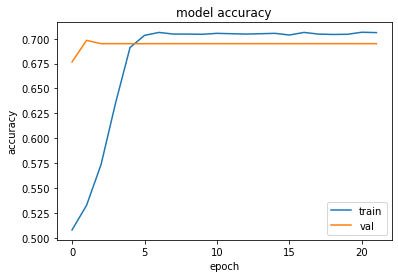

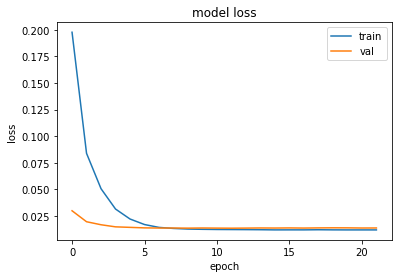

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [0]:
predictionsNN = model.predict(X_test)
print(predictionsNN.shape)

(600, 2)


In [0]:
Get_score(predictionsNN, Y_test)

The Spearman's correlation coefficient is: 0.453
The Spearman's correlation coefficient is: 0.190


#### Using C3D Features

In [0]:
#Short term and long term memorability score 
Y_NN = labels[['short-term_memorability','long-term_memorability']].values
X_NN = feature1

In [0]:
#Splitting dataset into test and train set with 90:10 ratio
X_train, X_test, Y_train, Y_test = train_test_split(X_NN,Y_NN, test_size=0.10, random_state=42)

In [0]:
# adding dropout and regularizers
model = Sequential()
model.add(layers.Dense(30,activation='selu',kernel_regularizer=regularizers.l2(0.00001)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(25,activation='selu',kernel_regularizer=regularizers.l2(0.00001)))
model.add(layers.Dropout(0.7))
model.add(layers.Dense(2,activation='selu'))

# compiling the model 
opt = optimizers.RMSprop(lr=0.0009, rho=0.89, decay=0.0)
model.compile(optimizer=opt,loss='mse',metrics=['accuracy'])

history = model.fit(X_train,Y_train,epochs=22,validation_data=(X_test,Y_test))

Train on 5400 samples, validate on 600 samples
Epoch 1/22
5400/5400 [==============================] - 0s 83us/step - loss: 0.3195 - accuracy: 0.4863 - val_loss: 0.0302 - val_accuracy: 0.5233
Epoch 2/22
5400/5400 [==============================] - 0s 51us/step - loss: 0.1057 - accuracy: 0.5217 - val_loss: 0.0196 - val_accuracy: 0.6900
Epoch 3/22
5400/5400 [==============================] - 0s 48us/step - loss: 0.0533 - accuracy: 0.5956 - val_loss: 0.0158 - val_accuracy: 0.6950
Epoch 4/22
5400/5400 [==============================] - 0s 48us/step - loss: 0.0324 - accuracy: 0.6546 - val_loss: 0.0161 - val_accuracy: 0.6950
Epoch 5/22
5400/5400 [==============================] - 0s 47us/step - loss: 0.0221 - accuracy: 0.6976 - val_loss: 0.0147 - val_accuracy: 0.6950
Epoch 6/22
5400/5400 [==============================] - 0s 48us/step - loss: 0.0176 - accuracy: 0.7057 - val_loss: 0.0146 - val_accuracy: 0.6950
Epoch 7/22
5400/5400 [==============================] - 0s 52us/step - loss: 0.0154

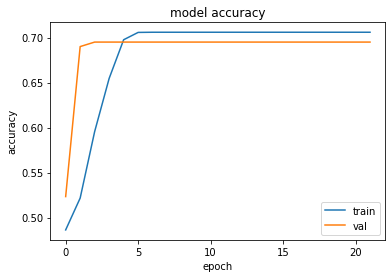

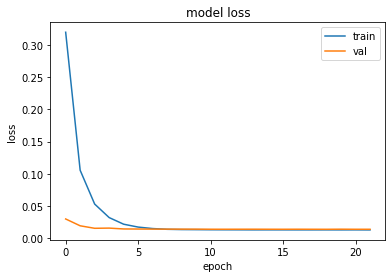

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [0]:
predictionsNN = model.predict(X_test)
print(predictionsNN.shape)

(600, 2)


In [0]:
Get_score(predictionsNN, Y_test)

The Spearman's correlation coefficient is: 0.292
The Spearman's correlation coefficient is: 0.142


#### Using HMP Features

In [0]:
#Short term and long term memorability score 
Y_NN = labels[['short-term_memorability','long-term_memorability']].values
X_NN = feature2

In [0]:
#Splitting dataset into test and train set with 90:10 ratio
X_train, X_test, Y_train, Y_test = train_test_split(X_NN,Y_NN, test_size=0.10, random_state=42)

In [0]:
# adding dropout and regularizers
model = Sequential()
model.add(layers.Dense(30,activation='selu',kernel_regularizer=regularizers.l2(0.00001)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(25,activation='selu',kernel_regularizer=regularizers.l2(0.00001)))
model.add(layers.Dropout(0.7))
model.add(layers.Dense(2,activation='selu'))

# compiling the model 
opt = optimizers.RMSprop(lr=0.0009, rho=0.89, decay=0.0)
model.compile(optimizer=opt,loss='mse',metrics=['accuracy'])

history = model.fit(X_train,Y_train,epochs=22,validation_data=(X_test,Y_test))

Train on 5400 samples, validate on 600 samples
Epoch 1/22
5400/5400 [==============================] - 1s 210us/step - loss: 0.1267 - accuracy: 0.5272 - val_loss: 0.0376 - val_accuracy: 0.6950
Epoch 2/22
5400/5400 [==============================] - 1s 180us/step - loss: 0.0623 - accuracy: 0.5633 - val_loss: 0.0160 - val_accuracy: 0.6950
Epoch 3/22
5400/5400 [==============================] - 1s 175us/step - loss: 0.0409 - accuracy: 0.5948 - val_loss: 0.0162 - val_accuracy: 0.6950
Epoch 4/22
5400/5400 [==============================] - 1s 173us/step - loss: 0.0283 - accuracy: 0.6580 - val_loss: 0.0163 - val_accuracy: 0.6950
Epoch 5/22
5400/5400 [==============================] - 1s 179us/step - loss: 0.0216 - accuracy: 0.6989 - val_loss: 0.0153 - val_accuracy: 0.6950
Epoch 6/22
5400/5400 [==============================] - 1s 186us/step - loss: 0.0176 - accuracy: 0.7054 - val_loss: 0.0148 - val_accuracy: 0.6950
Epoch 7/22
5400/5400 [==============================] - 1s 177us/step - loss:

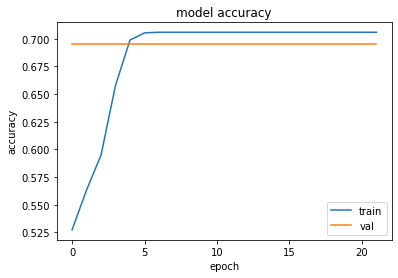

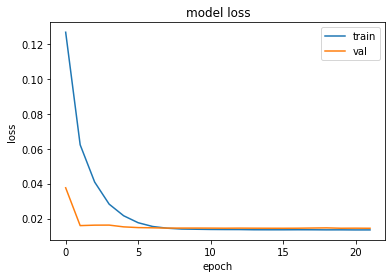

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [0]:
predictionsNN = model.predict(X_test)
print(predictionsNN.shape)

(600, 2)


In [0]:
Get_score(predictionsNN, Y_test)

The Spearman's correlation coefficient is: 0.279
The Spearman's correlation coefficient is: 0.134


#### Caption and C3D features combined together

In [0]:
#Short term and long term memorability score 
Y_NN = labels[['short-term_memorability','long-term_memorability']].values
X_NN = np.concatenate((captions,feature1), axis=1)

In [0]:
#Splitting dataset into test and train set with 90:10 ratio
X_train, X_test, Y_train, Y_test = train_test_split(X_NN,Y_NN, test_size=0.10, random_state=42)

In [0]:
# adding dropout and regularizers
model = Sequential()
model.add(layers.Dense(30,activation='selu',kernel_regularizer=regularizers.l2(0.00001)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(25,activation='selu',kernel_regularizer=regularizers.l2(0.00001)))
model.add(layers.Dropout(0.7))
model.add(layers.Dense(2,activation='selu'))

# compiling the model 
opt = optimizers.RMSprop(lr=0.0009, rho=0.89, decay=0.0)
model.compile(optimizer=opt,loss='mse',metrics=['accuracy'])

history = model.fit(X_train,Y_train,epochs=22,validation_data=(X_test,Y_test))

Train on 5400 samples, validate on 600 samples
Epoch 1/22
5400/5400 [==============================] - 1s 205us/step - loss: 0.2002 - accuracy: 0.5322 - val_loss: 0.0272 - val_accuracy: 0.6633
Epoch 2/22
5400/5400 [==============================] - 1s 165us/step - loss: 0.0929 - accuracy: 0.5528 - val_loss: 0.0173 - val_accuracy: 0.6833
Epoch 3/22
5400/5400 [==============================] - 1s 158us/step - loss: 0.0537 - accuracy: 0.5778 - val_loss: 0.0170 - val_accuracy: 0.6950
Epoch 4/22
5400/5400 [==============================] - 1s 160us/step - loss: 0.0331 - accuracy: 0.6143 - val_loss: 0.0142 - val_accuracy: 0.6950
Epoch 5/22
5400/5400 [==============================] - 1s 167us/step - loss: 0.0226 - accuracy: 0.6715 - val_loss: 0.0143 - val_accuracy: 0.6950
Epoch 6/22
5400/5400 [==============================] - 1s 161us/step - loss: 0.0168 - accuracy: 0.6987 - val_loss: 0.0139 - val_accuracy: 0.6950
Epoch 7/22
5400/5400 [==============================] - 1s 160us/step - loss:

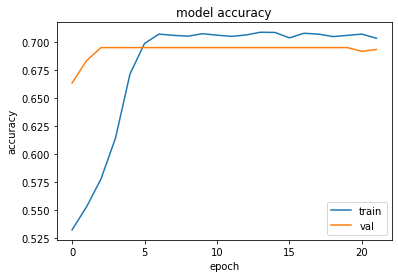

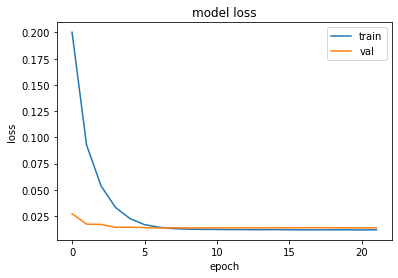

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [0]:
predictionsNN = model.predict(X_test)
print(predictionsNN.shape)

(600, 2)


In [0]:
Get_score(predictionsNN, Y_test)

The Spearman's correlation coefficient is: 0.460
The Spearman's correlation coefficient is: 0.182


#### Captions and HMP features combined together

In [0]:
#Short term and long term memorability score 
Y_NN = labels[['short-term_memorability','long-term_memorability']].values
X_NN = np.concatenate((captions,feature2), axis=1)

In [0]:
#Splitting dataset into test and train set with 90:10 ratio
X_train, X_test, Y_train, Y_test = train_test_split(X_NN,Y_NN, test_size=0.10, random_state=42)

In [0]:
# adding dropout and regularizers
model = Sequential()
model.add(layers.Dense(30,activation='selu',kernel_regularizer=regularizers.l2(0.00001)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(25,activation='selu',kernel_regularizer=regularizers.l2(0.00001)))
model.add(layers.Dropout(0.7))
model.add(layers.Dense(2,activation='selu'))

# compiling the model 
opt = optimizers.RMSprop(lr=0.0009, rho=0.89, decay=0.0)
model.compile(optimizer=opt,loss='mse',metrics=['accuracy'])

history = model.fit(X_train,Y_train,epochs=22,validation_data=(X_test,Y_test))

Train on 5400 samples, validate on 600 samples
Epoch 1/22
5400/5400 [==============================] - 2s 315us/step - loss: 0.1605 - accuracy: 0.5457 - val_loss: 0.0284 - val_accuracy: 0.6917
Epoch 2/22
5400/5400 [==============================] - 2s 291us/step - loss: 0.0775 - accuracy: 0.5867 - val_loss: 0.0249 - val_accuracy: 0.6850
Epoch 3/22
5400/5400 [==============================] - 2s 280us/step - loss: 0.0481 - accuracy: 0.6102 - val_loss: 0.0157 - val_accuracy: 0.6950
Epoch 4/22
5400/5400 [==============================] - 1s 262us/step - loss: 0.0320 - accuracy: 0.6589 - val_loss: 0.0143 - val_accuracy: 0.6950
Epoch 5/22
5400/5400 [==============================] - 1s 270us/step - loss: 0.0229 - accuracy: 0.6887 - val_loss: 0.0141 - val_accuracy: 0.6950
Epoch 6/22
5400/5400 [==============================] - 1s 269us/step - loss: 0.0173 - accuracy: 0.7035 - val_loss: 0.0140 - val_accuracy: 0.6950
Epoch 7/22
5400/5400 [==============================] - 1s 275us/step - loss:

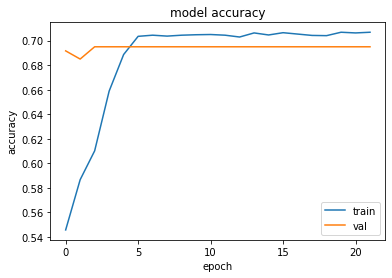

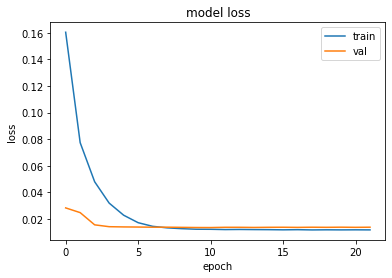

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [0]:
predictionsNN = model.predict(X_test)
print(predictionsNN.shape)

(600, 2)


In [0]:
Get_score(predictionsNN, Y_test)

The Spearman's correlation coefficient is: 0.462
The Spearman's correlation coefficient is: 0.176


#### C3D and HMP features combined together

In [0]:
#Short term and long term memorability score 
Y_NN = labels[['short-term_memorability','long-term_memorability']].values
X_NN = np.concatenate((feature1,feature2), axis=1)

In [0]:
#Splitting dataset into test and train set with 90:10 ratio
X_train, X_test, Y_train, Y_test = train_test_split(X_NN,Y_NN, test_size=0.10, random_state=42)

In [0]:
# adding dropout and regularizers
model = Sequential()
model.add(layers.Dense(30,activation='selu',kernel_regularizer=regularizers.l2(0.00001)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(25,activation='selu',kernel_regularizer=regularizers.l2(0.00001)))
model.add(layers.Dropout(0.7))
model.add(layers.Dense(2,activation='selu'))

# compiling the model 
opt = optimizers.RMSprop(lr=0.0009, rho=0.89, decay=0.0)
model.compile(optimizer=opt,loss='mse',metrics=['accuracy'])

history = model.fit(X_train,Y_train,epochs=22,validation_data=(X_test,Y_test))

Train on 5400 samples, validate on 600 samples
Epoch 1/22
5400/5400 [==============================] - 1s 222us/step - loss: 0.1278 - accuracy: 0.5506 - val_loss: 0.0262 - val_accuracy: 0.6950
Epoch 2/22
5400/5400 [==============================] - 1s 188us/step - loss: 0.0643 - accuracy: 0.5783 - val_loss: 0.0168 - val_accuracy: 0.6950
Epoch 3/22
5400/5400 [==============================] - 1s 183us/step - loss: 0.0408 - accuracy: 0.6241 - val_loss: 0.0162 - val_accuracy: 0.6950
Epoch 4/22
5400/5400 [==============================] - 1s 188us/step - loss: 0.0292 - accuracy: 0.6735 - val_loss: 0.0146 - val_accuracy: 0.6950
Epoch 5/22
5400/5400 [==============================] - 1s 189us/step - loss: 0.0219 - accuracy: 0.6998 - val_loss: 0.0146 - val_accuracy: 0.6950
Epoch 6/22
5400/5400 [==============================] - 1s 184us/step - loss: 0.0175 - accuracy: 0.7061 - val_loss: 0.0148 - val_accuracy: 0.6950
Epoch 7/22
5400/5400 [==============================] - 1s 189us/step - loss:

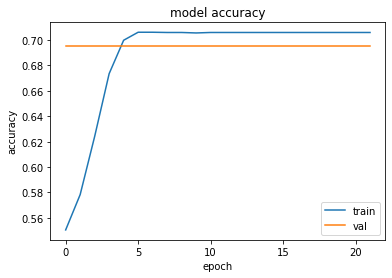

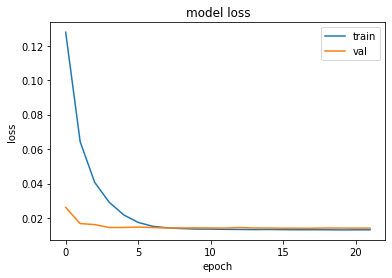

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [0]:
predictionsNN = model.predict(X_test)
print(predictionsNN.shape)

(600, 2)


In [0]:
Get_score(predictionsNN, Y_test)

The Spearman's correlation coefficient is: 0.312
The Spearman's correlation coefficient is: 0.149


#### C3D + HMP + Captions

In [0]:
#Short term and long term memorability score 
Y_NN = labels[['short-term_memorability','long-term_memorability']].values
X_NN = np.concatenate((feature1,feature2,captions), axis=1)

In [0]:
#Splitting dataset into test and train set with 90:10 ratio
X_train, X_test, Y_train, Y_test = train_test_split(X_NN,Y_NN, test_size=0.10, random_state=42)

In [0]:
# adding dropout and regularizers
model = Sequential()
model.add(layers.Dense(30,activation='selu',kernel_regularizer=regularizers.l2(0.00001)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(25,activation='selu',kernel_regularizer=regularizers.l2(0.00001)))
model.add(layers.Dropout(0.7))
model.add(layers.Dense(2,activation='selu'))

# compiling the model 
opt = optimizers.RMSprop(lr=0.0009, rho=0.89, decay=0.0)
model.compile(optimizer=opt,loss='mse',metrics=['accuracy'])

history = model.fit(X_train,Y_train,epochs=22,validation_data=(X_test,Y_test))

Train on 5400 samples, validate on 600 samples
Epoch 1/22
5400/5400 [==============================] - 2s 340us/step - loss: 0.1757 - accuracy: 0.5144 - val_loss: 0.0424 - val_accuracy: 0.6617
Epoch 2/22
5400/5400 [==============================] - 2s 304us/step - loss: 0.0833 - accuracy: 0.5691 - val_loss: 0.0217 - val_accuracy: 0.6917
Epoch 3/22
5400/5400 [==============================] - 2s 292us/step - loss: 0.0490 - accuracy: 0.6089 - val_loss: 0.0170 - val_accuracy: 0.6917
Epoch 4/22
5400/5400 [==============================] - 2s 294us/step - loss: 0.0324 - accuracy: 0.6470 - val_loss: 0.0149 - val_accuracy: 0.6950
Epoch 5/22
5400/5400 [==============================] - 2s 302us/step - loss: 0.0227 - accuracy: 0.6850 - val_loss: 0.0143 - val_accuracy: 0.6950
Epoch 6/22
5400/5400 [==============================] - 2s 299us/step - loss: 0.0169 - accuracy: 0.7043 - val_loss: 0.0138 - val_accuracy: 0.6950
Epoch 7/22
5400/5400 [==============================] - 2s 297us/step - loss:

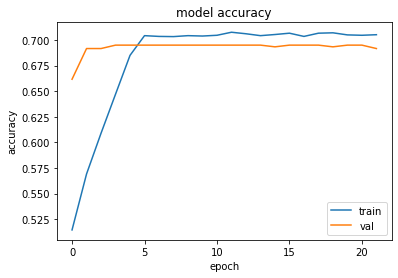

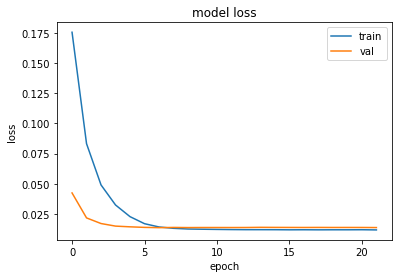

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [0]:
predictionsNN = model.predict(X_test)
print(predictionsNN.shape)

(600, 2)


In [0]:
Get_score(predictionsNN, Y_test)

The Spearman's correlation coefficient is: 0.465
The Spearman's correlation coefficient is: 0.204


### Regression Techniques


> As we have seen in the Neural Network section we can choose the feature we need and load it into out 'X' Variabel
*    To reduce the code I will be exhibiting the model with best results among the features 

You are free to change the features if need be, please see the R-CNN section above for the code snippet.



#### Linear Regression

In [0]:
#Short term and long term memorability score 
Y_LR = labels[['short-term_memorability','long-term_memorability']].values
X_LR = feature1

In [0]:
#Splitting dataset into test and train set with 90:10 ratio
X_train, X_test, Y_train, Y_test = train_test_split(X_LR,Y_LR, test_size=0.20, random_state=42)

In [0]:
from sklearn.linear_model import LinearRegression

#Creating A Linear Regression Model
lr = LinearRegression(normalize=True)

#Training the model
history = lr.fit(X_train,Y_train)

In [0]:
predictionsLR = lr.predict(X_test)
print(predictionsLR.shape)

(1200, 2)


In [0]:
Get_score(predictionsLR, Y_test)

The Spearman's correlation coefficient is: 0.277
The Spearman's correlation coefficient is: 0.103


#### Support Vector Regression -- SVR

###### Short Term Memorability

In [0]:
from sklearn.svm import SVR

In [0]:
Y_short = labels[['short-term_memorability']].values
X_SVR = np.concatenate((feature1,feature2,captions), axis=1)

In [0]:
#Splitting dataset into test and train set with 90:10 ratio
X_train, X_test, Y_train_short, Y_test_short = train_test_split(X_SVR,Y_short, test_size=0.1, random_state=42)

In [0]:
print(len(X_SVR),Y_short.shape)

6000 (6000, 1)


In [0]:
#Creating an SVR model
modelSVR_short = SVR(C=100).fit(X_train,Y_train_short)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
predictionsSVR_short = modelSVR_short.predict(X_test)

In [0]:
Get_score(predictionsSVR_short,Y_test_short)

The Spearman's correlation coefficient is: 0.467


###### Long Term Memorability

In [0]:
from sklearn.svm import SVR

In [0]:
Y_long = labels[['long-term_memorability']].values
X_SVR = np.concatenate((feature1,captions,feature2), axis=1)

In [0]:
#Splitting dataset into test and train set with 90:10 ratio
X_train, X_test, Y_train_long, Y_test_long = train_test_split(X_SVR,Y_long, test_size=0.1, random_state=42)

In [0]:
print(len(X_SVR),Y_short.shape)

6000 (6000, 1)


In [0]:
modelSVR_long = SVR(C=100).fit(X_train,Y_train_long)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
predictionsSVR_long = modelSVR_long.predict(X_test)

In [0]:
Get_score(predictionsSVR_long,Y_test_long)

The Spearman's correlation coefficient is: 0.150


#### Regid Regression

In [0]:
Y_NN = labels[['short-term_memorability','long-term_memorability']].values
X_NN =np.concatenate((captions,feature1,feature2), axis=1)

In [0]:
#Splitting dataset into test and train set with 90:10 ratio
X_train, X_test, Y_train, Y_test = train_test_split(X_NN,Y_NN, test_size=0.10, random_state=42)

In [0]:
print(X_train.shape,Y_train.shape)

(5400, 11274) (5400, 2)


In [0]:
from sklearn.linear_model import Ridge
clf = Ridge()

#Creating an Rigid Regression Model 
clf.set_params(alpha=45)
model = clf.fit(X_train, Y_train) 

In [0]:
predictionsRR = model.predict(X_test)

In [0]:
predictionsRR.shape

(600, 2)

In [0]:
Get_score(predictionsRR, Y_test)

The Spearman's correlation coefficient is: 0.488
The Spearman's correlation coefficient is: 0.204


#### Random Forest

In [0]:
from sklearn.ensemble import RandomForestRegressor

In [0]:
#Short term and long term memorability score 
Y_RF = labels[['short-term_memorability','long-term_memorability']].values
X_RF = np.concatenate((feature1,feature2,captions), axis=1)

In [0]:
#Splitting dataset into test and train set with 90:10 ratio
X_train, X_test, Y_train, Y_test = train_test_split(X_RF,Y_RF, test_size=0.10, random_state=42)

#setting parameters for Random Forest
rf = RandomForestRegressor(n_estimators=20,max_depth=10,random_state=50,verbose=2)

#training dataset
rf.fit(X_train,Y_train)

print(rf.decision_path(X_train))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.1s remaining:    0.0s


building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


(<5400x11378 sparse matrix of type '<class 'numpy.longlong'>'
	with 1180799 stored elements in Compressed Sparse Row format>, array([    0,   445,  1096,  1759,  2270,  2945,  3546,  4151,  4504,
        4899,  5346,  5903,  6542,  7127,  7804,  8339,  8912,  9393,
       10076, 10607, 11378]))


In [0]:
predictionsRF = rf.predict(X_test)
print(predictionsRF.shape)

(600, 2)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


In [0]:
Get_score(predictionsRF,Y_test)

The Spearman's correlation coefficient is: 0.329
The Spearman's correlation coefficient is: 0.135


### Stacked Regression - Ensamble approach
> ensemble approach using
SVR, Decision Tree’s and Linear Regression as base
classifiers and Rigid Linear Regression as the final
estimator.

#### Short Term Memorability Score

In [0]:
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor

In [0]:
import numpy as np
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.linear_model import Ridge

#Short term and long term memorability score 
Y_Stack = labels[['short-term_memorability']].values
X_Stack = captions

In [0]:
#Splitting dataset into test and train set with 90 : 10 ratio
X_train, X_test, Y_train, Y_test = train_test_split(X_Stack,Y_Stack, test_size=0.10, random_state=42)

In [0]:
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

estimators = [
    ('regr', DecisionTreeRegressor(max_depth=10)),
    ('svr', SVR(C=100)),
    ('Lr',LinearRegression())
]
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(alpha=45)
)

model = reg.fit(X_train,Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_stacking.py:642: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.90849e-25): result may not be accurate.
  overwrite_a=True).T


In [0]:
StackPredictions = model.predict(X_test)

In [0]:
X_test.shape,Y_test.shape,StackPredictions.shape

((600, 5098), (600, 1), (600,))

In [0]:
Get_score(StackPredictions, Y_test)

The Spearman's correlation coefficient is: 0.461


#### Long Term Memorability Score

In [0]:
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor

In [0]:
import numpy as np
from sklearn.model_selection import cross_validate, cross_val_predict

#long term memorability score 
Y_Stack = labels[['long-term_memorability']].values
X_Stack = np.concatenate((captions,feature2), axis=1)

In [0]:
#Splitting dataset into test and train set with 90:10 ratio
X_train, X_test, Y_train, Y_test = train_test_split(X_Stack,Y_Stack, test_size=0.10, random_state=42)

In [0]:
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

estimators = [
    ('regr', DecisionTreeRegressor(max_depth=10)),
    ('svr', SVR(C=100)),
    ('Lr',LinearRegression())
]
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(alpha=45)
)

model = reg.fit(X_train,Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_stacking.py:642: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.53418e-23): result may not be accurate.
  overwrite_a=True).T


In [0]:
StackPredictions = model.predict(X_test)

In [0]:
X_test.shape,Y_test.shape,StackPredictions.shape

((600, 11173), (600, 1), (600,))

In [0]:
Get_score(StackPredictions, Y_test)

The Spearman's correlation coefficient is: 0.179


# Test Set Ground Truth Prediction


> We got the best Spearman Coefficient value using Rigid Regression with all the 3 features combined


*   Short Term Memorability Score : 0.488
*   Long Term Memorability Score : 0.203





#### Declaring Source Paths And Variables

In [0]:
# load the test set version of captions
cap_path = './Test-set/Captions_test/test-set-1_video-captions.txt'
df_cap_test=read_caps(cap_path)

label_path = './Test-set/Ground-truth_test/ground_truth_template.csv'
labels_test=pd.read_csv(label_path)

#Overwriting the Feat_Path to test dataset location
Feat_path = '/content/drive/My Drive/CA684_Assignment/Test-set/'

In [0]:
#Overwriting the functions for getting dataset name and full path since directory is named feature_test
def getnames(featurename):
  vnames = os.listdir(Feat_path+featurename+'_test')
  return vnames

def getpaths(featurename):
  fpath = [Feat_path+featurename+'_test/' + x for x in  getnames(featurename)]
  sorted = natsorted(fpath,alg=ns.IGNORECASE)
  print('Feature Path:')
  print(sorted[:5])
  return sorted

#### Cleaning / processing
> All processing is done in one cell to make it compact as detailed version is show in the above RCNN section 



In [0]:
df = df_cap_test.copy()
def strip_character(dataCol):
    r = re.compile(r'[^a-zA-Z]')
    return r.sub(' ', str(dataCol))

df['caption'] = df['caption'].apply(strip_character)

stop = stopwords.words('english') 
df['caption'] = df['caption'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))
df['caption'] = [''.join([WordNetLemmatizer().lemmatize(re.sub('[^A-Za-z]',' ',text)) for text in lis]) for lis in df['caption']]
df_combined = df_cap.append(df_cap_test,ignore_index = True)

counts = Counter()
for i, cap in enumerate(df_combined['caption']):
    counts.update(cap.split())

vect = TfidfVectorizer(ngram_range = (1,4)).fit(df_combined.caption)

vect_transformed_X_train = vect.transform(df_combined.caption)
len_token = len(vect.get_feature_names())

len_token = len(counts)
tokenizer = Tokenizer(num_words=len_token)

tokenizer.fit_on_texts(list(vect.get_feature_names()))

captions_test = tokenizer.texts_to_matrix(list(df_combined.caption.values),mode='binary')

In [0]:
print(len(captions_test))

8000


#### Loading 2000 C3D and HMP data point features from test set

In [0]:
#Loading 2000 test set of C3D
f1_test = df_C3D()

Feature Path:
['/content/drive/My Drive/CA684_Assignment/Test-set/C3D_test/video7494.txt', '/content/drive/My Drive/CA684_Assignment/Test-set/C3D_test/video7495.txt', '/content/drive/My Drive/CA684_Assignment/Test-set/C3D_test/video7496.txt', '/content/drive/My Drive/CA684_Assignment/Test-set/C3D_test/video7497.txt', '/content/drive/My Drive/CA684_Assignment/Test-set/C3D_test/video7498.txt']
Loading C3D
done


In [0]:
#Loading 2000 test set of HMP
f2_test = df_HMP()

Feature Path:
['/content/drive/My Drive/CA684_Assignment/Test-set/HMP_test/video7494.txt', '/content/drive/My Drive/CA684_Assignment/Test-set/HMP_test/video7495.txt', '/content/drive/My Drive/CA684_Assignment/Test-set/HMP_test/video7496.txt', '/content/drive/My Drive/CA684_Assignment/Test-set/HMP_test/video7497.txt', '/content/drive/My Drive/CA684_Assignment/Test-set/HMP_test/video7498.txt']
Loading HMP
done


In [0]:
print(len(f1_test),len(f2_test))

2000 2000


#### Rigid Linear Regression
> *    Training the model on 6000 data points present in the Dev-set
> *    Predicting the Short-Term and Long-Term Memorabilty score on 2000 data points present in Test-set

In [0]:
from sklearn.linear_model import Ridge

In [0]:
X_train = np.concatenate((captions_test[:6000],feature1,feature2), axis=1)
X_test = np.concatenate((captions_test[6000:8000],f1_test,f2_test), axis=1)
Y_train = labels[['short-term_memorability','long-term_memorability']].values
Y_test = []

In [0]:
print(len(X_train),len(Y_train),len(X_test))

6000 6000 2000


In [0]:
clf = Ridge()
clf.set_params(alpha=45)
model = clf.fit(X_train, Y_train)

In [0]:
predictionsRR_test = model.predict(X_test)

In [0]:
print(predictionsRR_test)

[[0.83155629 0.75244391]
 [0.76058739 0.72818616]
 [0.92157398 0.82433218]
 ...
 [0.87830783 0.77364832]
 [0.86657811 0.79420367]
 [0.91854426 0.82374575]]


#### Saving Predictions to a file

> Creating a panda dataframe to write to a csv **file**



In [0]:
Features = pd.DataFrame({'video': natsorted(labels_test['video']),
                    'short-term_memorability': [row[0] for row in predictionsRR_test],
                    'long-term_memorability':[row[1] for row in predictionsRR_test]
                        })

In [0]:
Features.head()

,video,short-term_memorability,long-term_memorability
0,7494,0.831556,0.752444
1,7495,0.760587,0.728186
2,7496,0.921574,0.824332
3,7497,0.880603,0.787601
4,7498,0.856447,0.758108


In [0]:
Features.to_csv('/content/drive/My Drive/predictions/test_predictions.csv')

# References

* https://pypi.org/project/PyPrind/
* https://en.wikipedia.org/wiki/Keras
* https://www.tensorflow.org/
* https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient
* https://github.com/dazcona/memorability

